# Obligatorio - Taller Agentes Inteligentes 2025

**Estudiante: Germán Otero**

**Número de estudiante: 138796**

En este trabajo obligatorio aplicaremos los conceptos vistos en el curso para diseñar, implementar y evaluar agentes capaces de aprender a jugar al clásico **Breakout** de Atari, utilizando el entorno provisto por Farama Gymnasium ([https://ale.farama.org/environments/breakout/](https://ale.farama.org/environments/breakout/)).

<p align="center">
  <img src="https://media.tenor.com/oMxHgRrISJsAAAAM/atari-deep-learning.gif" alt="Atari Deep Learning"/>
</p>


El ejercicio se enmarca en un contexto de aprendizaje práctico, donde trabajaremos con las interfaces estándar de Gymnasium para:

1. **Profundizar en algoritmos de valor**: implementaremos y compararemos dos variantes de Q-Learning basadas en redes neuronales profundas:
   * **Deep Q Learning (DQN)**
   * **Double Deep Q Learning (DDQN)**
2. **Evaluar rendimiento y estabilidad**: registraremos las recompensas obtenidas durante el entrenamiento de cada agente y analizaremos su comportamiento mediante gráficas comparativas.
3. **Demostrar resultados de forma visual**: capturaremos vídeos que muestren a cada agente “resolviendo” el entorno, entendido como la habilidad de romper al menos cinco bloques en una partida.

Debido a las limitaciones de tiempo y cómputo propias de un entorno de curso, no se espera entrenar modelos durante más de diez horas por agente. Por ello, será fundamental:

* Integrar puntos de **checkpoint** para guardar periódicamente los pesos de la red.
* Seguir en los puntos 2 y 3 la arquitectura y técnicas originales propuestas en los papers seminales de DQN y DDQN, dejando la experimentación adicional para el punto extra.
* Flexibilizar la notebook de guía: pueden reorganizarla o dividirla en múltiples archivos según su conveniencia.


## Objetivos y tareas

1. **Completar la implementación**
   * Rellenar el código faltante en la notebook y en los módulos auxiliares para que los agentes puedan interactuar con el entorno de Breakout.
2. **Entrenar agentes**
   * Ajustar y entrenar un **DQN** que alcance la condición de “resolver” (romper ≥ 10 bloques).
   * Ajustar y entrenar un **DDQN** con la misma meta de desempeño.
3. **Visualizar y analizar resultados**
   * Generar **gráficas comparativas** de las recompensas obtenidas por ambos agentes en el mismo entorno (una gráfica por ambiente). Además se sugiere gráficas que muestren el valor de la función de valor Q para cada agente.
   * Extraer **al menos dos conclusiones** por gráfica, comentando diferencias en convergencia, estabilidad y comportamiento exploratorio.
4. **Registro de demostraciones**
   * Grabar y entregar un **video demostrativo** de cada agente resolviendo el entorno.
5. **Experimentación**
   * Probar otras arquitecturas, técnicas de mejora o módulos de procesamiento de entradas más avanzados, documentando brevemente su impacto/

## Criterios de evaluación

| Criterio                                  | Descripción                                                  | Peso |
| ----------------------------------------- | ------------------------------------------------------------ | ---- |
| **Implementación y rendimiento**          | DQN y DDQN completados; cada agente rompe ≥ 10 bloques       | 40%  |
| **Estructura y narrativa de la notebook** | Secciones claras, explicación de decisiones, “historia”      | 20%  |
| **Análisis de resultados**                | Gráficas comparativas; ≥ 2 conclusiones por gráfico          | 20%  |
| **Presentación visual**                   | Vídeos demostrativos de cada agente                          | 10%  |
| **Experimentación**                       | Experimentación adicional documentada y analizada brevemente | 10%  |

## Bibliografía

* **Mnih, V.**, Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2013). *Playing Atari with Deep Reinforcement Learning*. [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)
* **van Hasselt, H.**, Guez, A., & Silver, D. (2015). *Deep Reinforcement Learning with Double Q-learning*. [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)
* **Sutton, R. S.**, & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.), capítulo 16.5: “Human-level Video Game Play”. MIT Press.

## Setup

**Acceso a Google Drive para persistencia**

In [ ]:
import os
import sys
# Validamos si estamos en Google Colab, y cargamos
# las librerías necesarias y montamos
# la carpeta de trabajo.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import google.colab
    IN_COLAB = True
    print("Ejecutando desde Google Colab")
except:
    print("Ejecutando de forma local")
    IN_COLAB = False

# Agregamos módulos necesarios
if IN_COLAB:
  !pip install torchinfo

if IN_COLAB:
  import sys
  import os
  BASE_DIR = '/content/drive/MyDrive/2025obltalleria_v6'
  sys.path.append(BASE_DIR)
else:
  BASE_DIR = os.getcwd()  # si no estamos en Colab, usamos el directorio actual
  sys.path.append(BASE_DIR)

Ejecutando de forma local


**Imports**

In [ ]:
import os
import torch
import numpy as np
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import gymnasium
import ale_py
from utils import make_env, show_observation_stack, plot_rewards, get_timestamp, save_numpy_array, load_numpy_array, load_model_checkpoint
from IPython.display import Video

ALE (Atari Learning Environment) es un entorno de aprendizaje para videojuegos de Atari. En este caso, utilizaremos el entorno de Breakout. Es necesario entender que se separa el entorno de los roms de Atari, que son los juegos en sí. El entorno de ALE permite interactuar con los juegos de Atari a través de una API estándar, facilitando la implementación de algoritmos de aprendizaje por refuerzo.

Debemos instalar los roms por separado, para ello primero tenemos que saber donde están los roms de Atari.

In [ ]:
gymnasium.register_envs(ale_py) # registramos todos los entornos de ale_py
ruta_init = ale_py.roms.__file__ # debemos saber donde se encuentra la carpeta roms
ALE_ROMS_PATH = os.path.dirname(ruta_init)
print(ALE_ROMS_PATH)

/opt/conda/lib/python3.12/site-packages/ale_py/roms


In [ ]:
print(f"ROMs path: {ALE_ROMS_PATH}")

ROMs path: /opt/conda/lib/python3.12/site-packages/ale_py/roms


Podemos usar los siguientes comando para instalar los roms y colocalos en la carpeta correcta.

In [ ]:
# !pip install "autorom[accept-rom-license]"
# !AutoROM --accept-license --install-dir {ALE_ROMS_PATH}

Fijamos la semilla para que los resultados sean reproducibles

In [ ]:
SEED = 24

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True # https://discuss.pytorch.org/t/what-is-the-differenc-between-cudnn-deterministic-and-cudnn-benchmark/38054
torch.backends.cudnn.benchmark=True # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/4
np.random.seed(SEED)
random.seed(SEED)

Vemos que dispositivo tenemos, si es GPU, MPS o CPU. **El uso de GPU es altamente recomendable** para acelerar el entrenamiento de los modelos.

In [ ]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Device: {DEVICE}")

Device: cuda


## Preprocesando Atari

Para reproducir fielmente el enfoque de Mnih et al. (2013) y reducir la carga computacional al trabajar con imágenes de Atari (210 × 160 píxeles, 128 colores), aplicamos el siguiente preprocesado φ a las últimas **4** frames del entorno:

1. **Conversión a escala de grises**
   Eliminamos la información de color (GRAYSCALE = True), pues la luminosidad es suficiente para capturar la dinámica de juego y reduce drásticamente la dimensionalidad de la entrada.

2. **Down-sampling y recorte**
   * Redimensionamos la imagen original a 110 × 84 píxeles, manteniendo la proporción horizontal.
   * Recortamos un área central de 84 × 84 píxeles que contiene la “zona de juego”, descartando bordes innecesarios.
     Este paso (SCREEN_SIZE = 84) no solo concentra la atención del modelo en la región relevante, sino que también garantiza un tamaño cuadrado compatible con las implementaciones de convoluciones en GPU.

3. **Saltos temporales (frame skipping)**
   Procesamos cada 4 frames (SKIP_FRAMES = 4), repitiendo la misma acción durante esos pasos. Esto reduce la redundancia temporal, acelera el entrenamiento y mantiene la coherencia del movimiento de la paleta y la bola.

4. **Apilamiento de frames**
   Finalmente, acumulamos las últimas 4 imágenes preprocesadas (NUM_STACKED_FRAMES = 4) en un único tensor de entrada. Así el agente puede inferir la velocidad y dirección de los elementos móviles a partir de la diferencia entre frames.

Este esquema de preprocesado es fundamental para disminuir el espacio de entrada, acelerar las convoluciones y proporcionar al Q-net una representación compacta y rica en información dinámica, tal como se describe en el algoritmo 1 del paper original .

> Se recomienda ver el método `make_env` en el archivo `utils.py` para entender cómo se implementa este preprocesado.

In [ ]:
GRAY_SCALE = True # si True, convertimos la imagen a escala de grises
SCREEN_SIZE = 84 # redimensionamos a SCREEN_SIZExSCREEN_SIZE
NUM_STACKED_FRAMES = 4 # apilamos NUM_STACKED_FRAMES frames
SKIP_FRAMES = 4 # saltamos SKIP_FRAMES frames (haciendo la misma acción)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


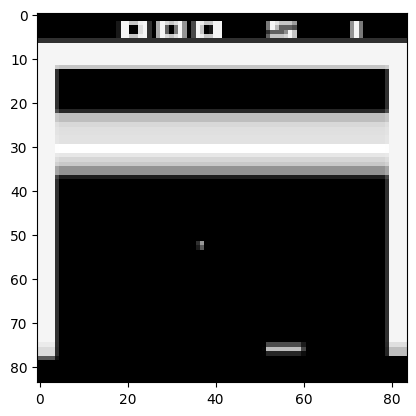

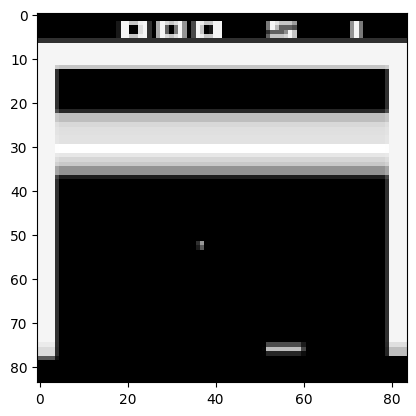

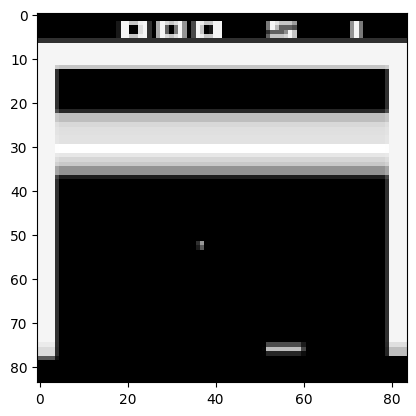

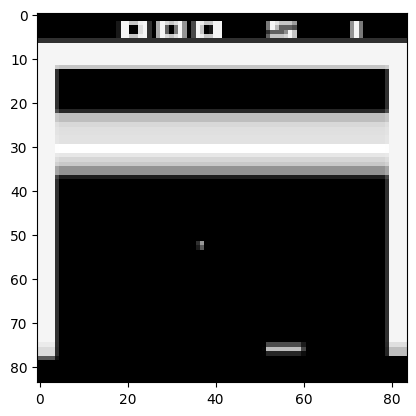

Episode 1 finished with total reward: 0


In [ ]:
# https://ale.farama.org/environments/breakout/
ENV_NAME = "ALE/Breakout-v5"

env = make_env(ENV_NAME,
                video_folder=BASE_DIR + '/videos/random',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

for episode_num in range(1):
    obs, info = env.reset()
    show_observation_stack(obs)
    reward_total = 0
    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # seleccionamos una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(action)
        reward_total += reward
        episode_over = terminated or truncated
    print(f"Episode {episode_num + 1} finished with total reward: {reward_total}")

env.close()

Además, podemos mostrar los videos capturados por el entorno de Atari de la siguiente manera:

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = BASE_DIR + "/videos/random/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

# Exploración del entorno

In [ ]:
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions shape: Discrete(4)
Observation shape: (4, 84, 84)
(4, 84, 84),
 0,
 False,
 {'lives': 5, 'episode_frame_number': 9, 'frame_number': 494}


### Acciones
...

### Observaciones
...

# Deep Q Learning

Deep Q Learning extiende el algoritmo clásico de Q-learning al emplear una **red neuronal profunda** como aproximador de la función de valor $Q(s,a)$. Inspirado en Mnih et al. (2013), este método utiliza una **red convolucional** para procesar directamente las imágenes del entorno Atari, un **replay buffer** para romper la correlación temporal de las muestras. La política sigue un esquema **ε-greedy**, balanceando exploración y explotación, y se entrena minimizando el error de la ecuación de Bellman sobre lotes de transiciones muestreadas de manera aleatoria.

<p align="center">
  <img src="https://www.researchgate.net/profile/Faris-Mismar/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png" alt="DQN"/>
</p>

Fuente: [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)

## Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


> Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**

In [ ]:
from replay_memory import ReplayMemory, Transition

# Creamos la memoria de repetición
replay_memory = ReplayMemory(3)

# Añadimos transiciones a la memoria (solo las 3 últimas se guardan)
replay_memory.add('state1', 'action1', 'reward1', 'done1', 'next_state1' )
replay_memory.add('state2', 'action2', 'reward2', 'done2', 'next_state2')
replay_memory.add('state3', 'action3', 'reward3', 'done3', 'next_state3')
replay_memory.add('state4', 'action4', 'reward4', 'done4', 'next_state4')

# Mostramos el tamaño de la memoria
print(f"Memory size: {len(replay_memory)}\n")

# Mostramos un sample de la memoria
sampled = replay_memory.sample(2)
print(f"Memory sample:")
for i, sample in enumerate(sampled):
    print(f"Sample {i}: {sample}")


Memory size: 3

Memory sample:
Sample 0: Transition(state='state3', action='action3', reward='reward3', done='done3', next_state='next_state3')
Sample 1: Transition(state='state2', action='action2', reward='reward2', done='done2', next_state='next_state2')


## Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

> Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**. Se recomienda empezar por una arquitectura simple como la que se muestra en el paper de Mnih et al. (2013) y luego experimentar con arquitecturas más complejas.

In [ ]:
from dqn_cnn_model import DQN_CNN_Model

env = make_env(ENV_NAME,
                record_every=None,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)

env.close()

cnn_model = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
summary(cnn_model, input_size=(32, SKIP_FRAMES, SCREEN_SIZE, SCREEN_SIZE), device=DEVICE) # 32 es el batch size

Actions shape: Discrete(4)
Observation shape: (4, 84, 84)


Layer (type:depth-idx)                   Output Shape              Param #
DQN_CNN_Model                            [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 20, 20]          4,112
├─Conv2d: 1-2                            [32, 32, 9, 9]            8,224
├─Linear: 1-3                            [32, 256]                 663,808
├─Linear: 1-4                            [32, 4]                   1,028
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 95.22
Input size (MB): 3.61
Forward/backward pass size (MB): 2.37
Params size (MB): 2.71
Estimated Total Size (MB): 8.69

La red esta definida para que reciba un tensor de 4 dimensiones (batch_size, num_frames, height, width) y devuelve un tensor de 2 dimensiones (batch_size, num_actions). La función `forward` es la encargada de definir el flujo de datos a través de la red. En este caso, se utiliza una red convolucional seguida de capas totalmente conectadas

In [ ]:
obs_tensor_batch = torch.rand((NUM_STACKED_FRAMES,SCREEN_SIZE,SCREEN_SIZE)).unsqueeze(0).to(DEVICE) # Añadimos una dimensión para el batch y lo pasamos al dispositivo


In [ ]:
# Verificamos el shape del tensor de entrada
# el cual deberá ser de (1, números de cuadros, 84, 84)
# Durante nuestro entrenamiento, la primera dimensión
# será el tamaño del batch, pero en este caso, al crearse
# una sola muestra, el tamaño es 1.
print(f"Shape del tensor de entrada: {obs_tensor_batch.shape}")

Shape del tensor de entrada: torch.Size([1, 4, 84, 84])


Los valores de Q se obtienen a partir de la salida de la red, cada columna representa el valor Q para cada acción posible en el estado actual.

In [ ]:
print(f"Q-values shape: {cnn_model(obs_tensor_batch).shape}") # shape: (1, num_actions)

Q-values shape: torch.Size([1, 4])


In [ ]:
cnn_model(obs_tensor_batch)

tensor([[ 0.0396, -0.0135, -0.0619, -0.0496]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Podemos preguntar cuál es la acción con mayor valor Q en un estado.

In [ ]:
cnn_model(obs_tensor_batch).max(1)

torch.return_types.max(
values=tensor([0.0396], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

En el siguiente ejemplo vamos a ver cómo tomar los valores de acciones deseables para un conjunto de estados.

In [ ]:
# Creamos 3 observaciones aleatorias para probar el modelo
obs_ran1 = torch.rand(4, 84, 84)
obs_ran2 = torch.rand(4, 84, 84)
obs_ran3 = torch.rand(4, 84, 84)

batch = torch.stack([obs_ran1, obs_ran2, obs_ran3], dim=0).to(DEVICE) # shape: (3, 4, 84, 84)
print(f"Batch shape: {batch.shape}")

actions =  torch.tensor([1, 2, 3], device=DEVICE).unsqueeze(1) # queremos la acción 1 para la primera observación, la acción 2 para la segunda y la acción 3 para la tercera
print(actions.shape)

Q_test = cnn_model(batch)
print(f"Q-values: {Q_test}")
print(f"Q-values: {Q_test.gather(1, actions)}") # https://pytorch.org/docs/main/generated/torch.gather.html

Batch shape: torch.Size([3, 4, 84, 84])
torch.Size([3, 1])
Q-values: tensor([[ 0.0155, -0.0168, -0.0644, -0.0498],
        [ 0.0401, -0.0106, -0.0751, -0.0769],
        [ 0.0320, -0.0209, -0.0616, -0.0352]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Q-values: tensor([[-0.0168],
        [-0.0751],
        [-0.0352]], device='cuda:0', grad_fn=<GatherBackward0>)


## Phi

La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym. Esta función pasa una observación de gym a un tensor de Pytorch y la normaliza.

> Técnicamente la función phi tiene más responsabilidades, como la de apilar los frames y el downsampling. En nuestro caso se lo delegamos a los wrappers de gymnasium.

In [ ]:
def process_state(obs):
    """
    Preprocess the state to be used as input for the model (transform to tensor).
    """
    return torch.tensor(obs, dtype=torch.float32, device=DEVICE) / 255.0

obs, _ = env.reset()
obs_tensor = process_state(obs)
print(f"Observation shape: {obs_tensor.shape}")

Observation shape: torch.Size([4, 84, 84])


## Agente

Vamos a definir una clase agente (abstracto), encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

> Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py** y **dqn_agent.py**.

Funciones a completar:


1. **init**: que inicializa los parametros del agente.

2. **compute_epsilon**: que computa el valor actual de epsilon en base al número de pasos actuales y si esta entrenando o no.

3. **select_action**: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. **train**: que entrena el agente por un número dado de episodios de largo determinado.

5. **record_test_episode**: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

## Entrenamiento

In [ ]:
# Hiperparámetros
TOTAL_STEPS = 10_000_000
EPISODES = 20_000
STEPS_PER_EPISODE = 20_000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_ANNEAL_STEPS = 1_000_000

EPISODE_BLOCK = 100

BATCH_SIZE = 32
BUFFER_SIZE = 50_000

GAMMA = 0.995
LEARNING_RATE = 0.00025

In [ ]:
from dqn_agent import DQNAgent

env = make_env(ENV_NAME,
                video_folder=BASE_DIR + '/videos/dqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE)

dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

# Salvamos los rewards en disco, por si la sesión se desconecta
DATA_BASE_DIR = BASE_DIR + 'data/'
save_numpy_array(DATA_BASE_DIR, 'dqn_rewards', dqn_rewards)

env.close()

Entrenando:  43%|████▎     | 8501/20000 [3:23:53<6:58:39,  2.18s/episode, reward=9.26, epsilon=0.05, steps=2755571] 

Modelo guardado en ./data/dqn_model_10000.pth


Entrenando:  85%|████████▌ | 17001/20000 [6:44:39<36:49,  1.36episode/s, reward=1.7, epsilon=0.05, steps=5452389]   

Modelo guardado en ./data/dqn_model_17000.pth


Entrenando:  86%|████████▌ | 17209/20000 [6:48:36<41:46,  1.11episode/s, reward=2.1, epsilon=0.05, steps=5506868]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Gráficas y video de entrenamiento

A continuación, se grafican las rewards obtenidas, a lo largo del entrenamiento. Posteriormente, se obtiene un video con un episodio.

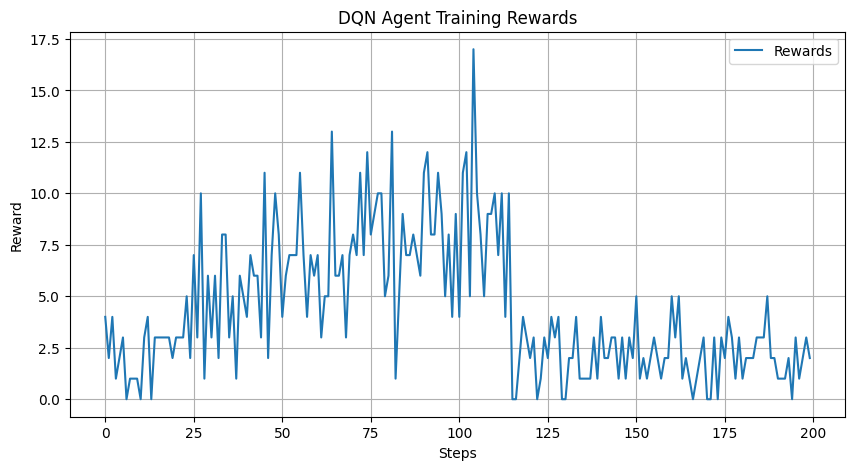

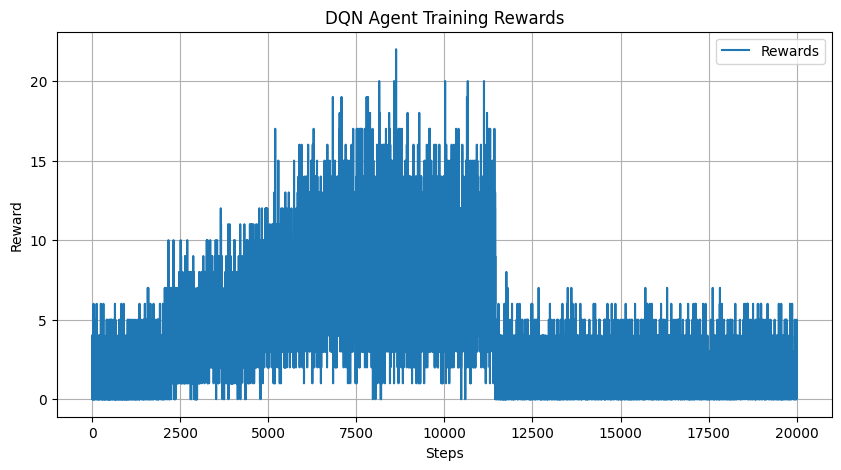

Modelo cargado desde ./data/dqn_model_8500.pth
{'lives': 5, 'episode_frame_number': 9, 'frame_number': 9}
{'lives': 5, 'episode_frame_number': 7, 'frame_number': 1092}
{'lives': 5, 'episode_frame_number': 9, 'frame_number': 2959}


In [ ]:
# Mostramos la evolución de las recomensas
dqn_rewards_2 = dqn_rewards[::100]
plot_rewards(dqn_rewards_2, title="DQN Agent Training Rewards") # Sin sampleado
plot_rewards(dqn_rewards, title="DQN Agent Training Rewards") # Con Sampleado


env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

# Luego, procedemos a cargar el modelo desde el archivo guardado.
net_loaded_from_disk = load_model_checkpoint(net, "./data/dqn_model_8500.pth")
dqn_agent = DQNAgent(env, net_loaded_from_disk, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE)
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

dqn_agent.play(env, episodes=3)

env.close()

# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/dqn_validation/breakout-episode-1.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

Como se puede observar, se obtienen 10 rewards, aunque posiblemente, existan modelos más óptimos que permitirian obtener rewards más altos. Lamentablemente, no se guardaron más modelos ya que en diferentes experimentaciones, se comprobó que el salvado del modelo, afecta el entrenamiento del mismo.
El modelo utilizado para la grabación del video, fue obtenido en el episodio 8500 aproximadamente. Si bien hubiera sido deseable obtener un modelo posterior, por lo comentado anteriormente, no se fueron obteniendo "muestras" con mayor frecuencia de los modelos, al afectar el entrenamiento del mismo.

# Double Deep Q Learning

Double DQN mejora la versión clásica de DQN corrigiendo el sesgo de sobreestimación de los valores
𝑄
Q. Para ello, desacopla la selección de la acción de su evaluación: en cada paso, la red online elige la acción que maximiza
𝑄
Q, pero la red objetivo distinta estima el valor de esa acción. Esta separación reduce el sesgo hacia valores demasiado optimistas y aporta mayor estabilidad al entrenamiento. El resto de la estructura —replay buffer, política ε-greedy, etc— se mantiene igual que en DQN, aprovechando así un diseño casi idéntico al original pero con resultados más fiables .

Fuente: [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)

> Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:
from double_dqn_agent import DoubleDQNAgent

env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )


modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block = EPISODE_BLOCK, device=DEVICE)

ddqn_rewards = ddqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

ddqn_agent.play(env, episodes=3)

env.close()

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/ddqn_validation/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

# Experimentación

## Exploración de parámetros para DQN

A continuación, buscaremos la combinación de hiperparámetros que permite obtener la mayor reward, para el caso DQN. Para ello, utilizaremos la herramienta "Weight and Biases" para explorar diferentes ejecuciones (runs) y obtener el mejor resultado.

In [ ]:
# Primero, realizamos el login en la herramienta
import wandb
wandb.login()

wandb: Currently logged in as: goterov (goterov-universidad-ort-uruguay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Ahora, inicializamos el proyecto y la ejecución
WANDB_TEAM_NAME = "goterov-universidad-ort-uruguay"
WANDB_PROJECT = "dqn-breakout"

sweep_config = {
    "name": "sweep-dqn-breakout",
    "method": "random",
    "metric": {"name": "reward", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0.0001},
        "episodes": {"values": [50]},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 64]},
        "gamma": {"distribution": "uniform", "max": 0.999, "min": 0.9},
        "epsilon_ini": {"distribution": "uniform", "max": 1.0, "min": 0.1},
        "epsilon_min": {"distribution": "uniform", "max": 0.1, "min": 0.01},
        "epsilon_anneal_steps": {"distribution": "int_uniform", "max": 1000000, "min": 100000},
        "episode_block": {"values": [10, 50, 100, 200]},
        "buffer_size": {"values": [10000, 50000]},
        "total_steps": {"values": [1_000]},
        "steps_per_episode": {"values": [1000, 5000, 10000]},
        "num_stacked_frames": {"values": [4]},
        "skip_frames": {"values": [4]},
        "screen_size": {"value": SCREEN_SIZE},
        "env_name": {"value": ENV_NAME},
        "device": {"value": DEVICE},
        "gray_scale": {"value": GRAY_SCALE},
        "wandb_team_name": {"value": WANDB_TEAM_NAME},
        "wandb_project": {"value": WANDB_PROJECT},
        "wandb_entity": {"value": "obltalleria"},
        "wandb_run_name": {"value": f"dqn_breakout_{get_timestamp()}"},
        "wandb_log_freq": {"value": 1000},
        "wandb_watch": {"value": True},
        "wandb_save_model": {"value": True},
        "wandb_log_rewards": {"value": True},
        "wandb_video_folder": {"value": BASE_DIR + '/videos/dqn_training/wandab'},
        "wandb_record_every": {"value": 500},
        "wandb_model_path": {"value": BASE_DIR + '/models/ddqn_breakout.pth'},
        "wandb_save_model_freq": {"value": 1000},
        "wandb_watch_freq": {"value": 1000},
        "wandb_log_rewards_freq": {"value": 1000},
        "wandb_video_freq": {"value": 500},
        "wandb_save_video": {"value": True},
        "wandb_save_rewards": {"value": True},
    },
}


In [ ]:
# Creamos el sweep en Weights & Biases
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: v7o5tczx
Sweep URL: https://wandb.ai/goterov-universidad-ort-uruguay/dqn-breakout/sweeps/v7o5tczx


In [ ]:
from dqn_agent import DQNAgent
import numpy

def process_state(obs):
    """
    Preprocess the state to be used as input for the model (transform to tensor).
    """
    return torch.tensor(obs, dtype=torch.float32, device=DEVICE) / 255.0

  # Definimos función de log, que servirá para los "runs"
  # y para Weight and Biases
def wand_log(episode, reward, duration):
    # Duration representa la duración del episodio, en el entendido
    # que también buscamos maximizar el tiempo que el agente
    # juega, y mantiene su jugada (por ejemplo, para el
    # caso que no rompa bloques, pero continúa
    # la partida).
    wandb.log({"episode": episode, "reward": reward, "duration": duration})

# Definimos la función "run" que se ejecutará en cada sweep
def run():
    # Inicializamos la ejecución de Weights & Biases
    wandb.init()

    # Obtenemos los hiperparámetros del sweep
    config = wandb.config

    # Creamos el entorno
    env = make_env(config.env_name,
                    video_folder=config.wandb_video_folder,
                    name_prefix=config.wandb_run_name,
                    record_every=config.wandb_record_every,
                    grayscale=config.gray_scale,
                    screen_size=config.screen_size,
                    stack_frames=config.num_stacked_frames,
                    skip_frames=config.skip_frames
                    )

    # Creamos el modelo DQN
    net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(config.device)

    # Creamos el agente DQN
    dqn_agent = DQNAgent(env, net, process_state, config.buffer_size, config.batch_size, config.learning_rate, config.gamma, epsilon_i=config.epsilon_ini, epsilon_f=config.epsilon_min, epsilon_anneal_steps=config.epsilon_anneal_steps, episode_block=config.episode_block, device=config.device)


    # Entrenamos al agente DQN
    dqn_rewards = dqn_agent.train(config.episodes, config.steps_per_episode, config.total_steps, wand_log, 1)

    # Guardamos los rewards en Weights & Biases
    wandb.log({"rewards": dqn_rewards})

     # Salvamos el mejor modelo
    torch.save(net.state_dict(), "model.pth")
    wandb.save("model.pth")

    # Finalizamos la ejecución de Weights & Biases
    wandb.finish()

    # Cerramos el entorno
    env.close()

In [ ]:
# Ejecutamos el sweep
wandb.agent(sweep_id, run, count=10)

wandb: Agent Starting Run: 8auwe623 with config:
wandb: 	batch_size: 64
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 10
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 508418
wandb: 	epsilon_ini: 0.11829221202595425
wandb: 	epsilon_min: 0.07067723302470484
wandb: 	gamma: 0.907611116260176
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.05242265429530717
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: adam
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 10000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_mod

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/videos/dqn_training/wandab folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:  10%|█         | 5/50 [00:05<00:47,  1.05s/episode, reward=2.2, epsilon=0.118, steps=1057, duration=1057]


duration,▃▃▁▁█
episode,▁▃▅▆█
reward,▃▃▁▁█
duration,341
episode,4
reward,5


wandb: Agent Starting Run: xduej4ae with config:
wandb: 	batch_size: 32
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 100
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 240053
wandb: 	epsilon_ini: 0.8262948830514565
wandb: 	epsilon_min: 0.0621824224360636
wandb: 	gamma: 0.938039733864099
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.02071527319977244
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: sgd
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 10000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_model

Entrenando:  14%|█▍        | 7/50 [00:05<00:32,  1.32episode/s, reward=1.14, epsilon=0.823, steps=1160, duration=1160]


duration,▃▃█▃▇▁▄
episode,▁▂▃▅▆▇█
reward,▅▅█▅█▁▅
duration,167
episode,6
reward,1


wandb: Agent Starting Run: der6svl2 with config:
wandb: 	batch_size: 64
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 50
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 789901
wandb: 	epsilon_ini: 0.5174315388500602
wandb: 	epsilon_min: 0.0834859781545019
wandb: 	gamma: 0.9736317917807836
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.08964598359373
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: sgd
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 5000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_model_fre

Entrenando:  14%|█▍        | 7/50 [00:05<00:34,  1.25episode/s, reward=1.29, epsilon=0.517, steps=1202, duration=1202]


duration,▁▁▃▇▇▁█
episode,▁▂▃▅▆▇█
reward,▁▁▃▆█▁█
duration,244
episode,6
reward,3


wandb: Agent Starting Run: 7i9c5i08 with config:
wandb: 	batch_size: 32
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 100
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 792078
wandb: 	epsilon_ini: 0.1449333800920968
wandb: 	epsilon_min: 0.0545570287826694
wandb: 	gamma: 0.925362651746343
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.04039772347869296
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: sgd
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 1000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_model_

Entrenando:  14%|█▍        | 7/50 [00:05<00:34,  1.25episode/s, reward=0.714, epsilon=0.145, steps=1141, duration=1141]


duration,▇▁▇▁▃█▄
episode,▁▂▃▅▆▇█
reward,█▁█▁▁▁▅
duration,152
episode,6
reward,1


wandb: Agent Starting Run: hmup7mi4 with config:
wandb: 	batch_size: 32
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 100
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 887037
wandb: 	epsilon_ini: 0.7608346333858695
wandb: 	epsilon_min: 0.06386302700063942
wandb: 	gamma: 0.936963055116078
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.09290800518354386
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: adam
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 10000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_mod

Entrenando:  12%|█▏        | 6/50 [00:05<00:37,  1.18episode/s, reward=1.33, epsilon=0.76, steps=1051, duration=1051]


duration,█▁▃▅▂▆
episode,▁▂▄▅▇█
reward,█▁▃▆▁▆
duration,204
episode,5
reward,2


wandb: Agent Starting Run: d5b77799 with config:
wandb: 	batch_size: 32
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 10
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 536028
wandb: 	epsilon_ini: 0.8250009070767464
wandb: 	epsilon_min: 0.08202101750111002
wandb: 	gamma: 0.9036138387271402
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.012407945506544346
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: adam
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 1000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_mod

Entrenando:  12%|█▏        | 6/50 [00:04<00:36,  1.21episode/s, reward=1.17, epsilon=0.824, steps=1027, duration=1027]


duration,█▃▂▆▁▃
episode,▁▂▄▅▇█
reward,█▃▁▆▁▃
duration,164
episode,5
reward,1


wandb: Agent Starting Run: 8870vyvv with config:
wandb: 	batch_size: 64
wandb: 	buffer_size: 50000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 100
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 545225
wandb: 	epsilon_ini: 0.3484138111506132
wandb: 	epsilon_min: 0.02097347150110044
wandb: 	gamma: 0.9818363324261132
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.01405758196974136
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: adam
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 1000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_mod

Entrenando:  12%|█▏        | 6/50 [00:05<00:40,  1.09episode/s, reward=1.33, epsilon=0.348, steps=1093, duration=1093]


duration,█▁▁█▅▄
episode,▁▂▄▅▇█
reward,▆▁▁█▆▃
duration,169
episode,5
reward,1


wandb: Agent Starting Run: qzzl5nwh with config:
wandb: 	batch_size: 64
wandb: 	buffer_size: 10000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 10
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 328356
wandb: 	epsilon_ini: 0.7668740429305796
wandb: 	epsilon_min: 0.012254203914070567
wandb: 	gamma: 0.932100707357296
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.07082088125563646
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: sgd
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 1000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_model

Entrenando:  10%|█         | 5/50 [00:05<00:51,  1.14s/episode, reward=2.8, epsilon=0.764, steps=1172, duration=1172]


duration,█▅▁▇▆
episode,▁▃▅▆█
reward,█▆▁█▆
duration,249
episode,4
reward,3


wandb: Agent Starting Run: ihnyypwp with config:
wandb: 	batch_size: 64
wandb: 	buffer_size: 10000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 100
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 298692
wandb: 	epsilon_ini: 0.5118845730794485
wandb: 	epsilon_min: 0.0916089334495904
wandb: 	gamma: 0.9916893880018228
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.02774675993894994
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: adam
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 1000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_mode

Entrenando:  12%|█▏        | 6/50 [00:05<00:37,  1.19episode/s, reward=1, epsilon=0.51, steps=1043, duration=1043]


duration,█▁▇▁▇▃
episode,▁▂▄▅▇█
reward,█▁▅▁█▅
duration,150
episode,5
reward,1


wandb: Agent Starting Run: psdmwyqv with config:
wandb: 	batch_size: 64
wandb: 	buffer_size: 10000
wandb: 	device: cuda
wandb: 	env_name: ALE/Breakout-v5
wandb: 	episode_block: 10
wandb: 	episodes: 50
wandb: 	epsilon_anneal_steps: 412245
wandb: 	epsilon_ini: 0.5619924857053219
wandb: 	epsilon_min: 0.04041290719412474
wandb: 	gamma: 0.945321322397491
wandb: 	gray_scale: True
wandb: 	learning_rate: 0.07315005728880358
wandb: 	num_stacked_frames: 4
wandb: 	optimizer: sgd
wandb: 	screen_size: 84
wandb: 	skip_frames: 4
wandb: 	steps_per_episode: 5000
wandb: 	total_steps: 1000
wandb: 	wandb_entity: obltalleria
wandb: 	wandb_log_freq: 1000
wandb: 	wandb_log_rewards: True
wandb: 	wandb_log_rewards_freq: 1000
wandb: 	wandb_model_path: /content/drive/MyDrive/2025obltalleria_v9_revisada_labort/models/ddqn_breakout.pth
wandb: 	wandb_project: dqn-breakout
wandb: 	wandb_record_every: 500
wandb: 	wandb_run_name: dqn_breakout_2025-07-13_05-39-08
wandb: 	wandb_save_model: True
wandb: 	wandb_save_model_

Entrenando:  12%|█▏        | 6/50 [00:05<00:38,  1.13episode/s, reward=1.33, epsilon=0.561, steps=1079, duration=1079]


duration,██▁▃▃▂
episode,▁▂▄▅▇█
reward,██▁▃▃▁
duration,141
episode,5
reward,0


In [ ]:

project_path = WANDB_TEAM_NAME + "/" + WANDB_PROJECT
print(project_path)

# Vamos a obtener la mejor ejecución, para obtener
# los mejores parámetros.

api = wandb.Api()
runs = api.runs(project_path)

# Get the best run based on a specific metric, e.g., max reward
best_run = sorted(
    runs,
    key=lambda run: run.summary.get("episode_reward", float("-inf")),
    reverse=True  # reverse=True for highest value (max), False for min
)[0]

print(best_run.summary.keys())

print("Best run ID:", best_run.id)
print("Run URL:", best_run.url)

goterov-universidad-ort-uruguay/dqn-breakout
dict_keys(['_runtime', '_step', '_timestamp', '_wandb', 'duration', 'episode', 'reward', 'rewards'])
Best run ID: 8auwe623
Run URL: https://wandb.ai/goterov-universidad-ort-uruguay/dqn-breakout/runs/8auwe623


A continuación, se muestra las gráficas de Weight and Bias, en donde se observan las ejecuciones y los resultados obtenidos. Como puede observarse, la ejecución de la sweep "royal-sweep-7" fue la que obtuvo mejores valores.

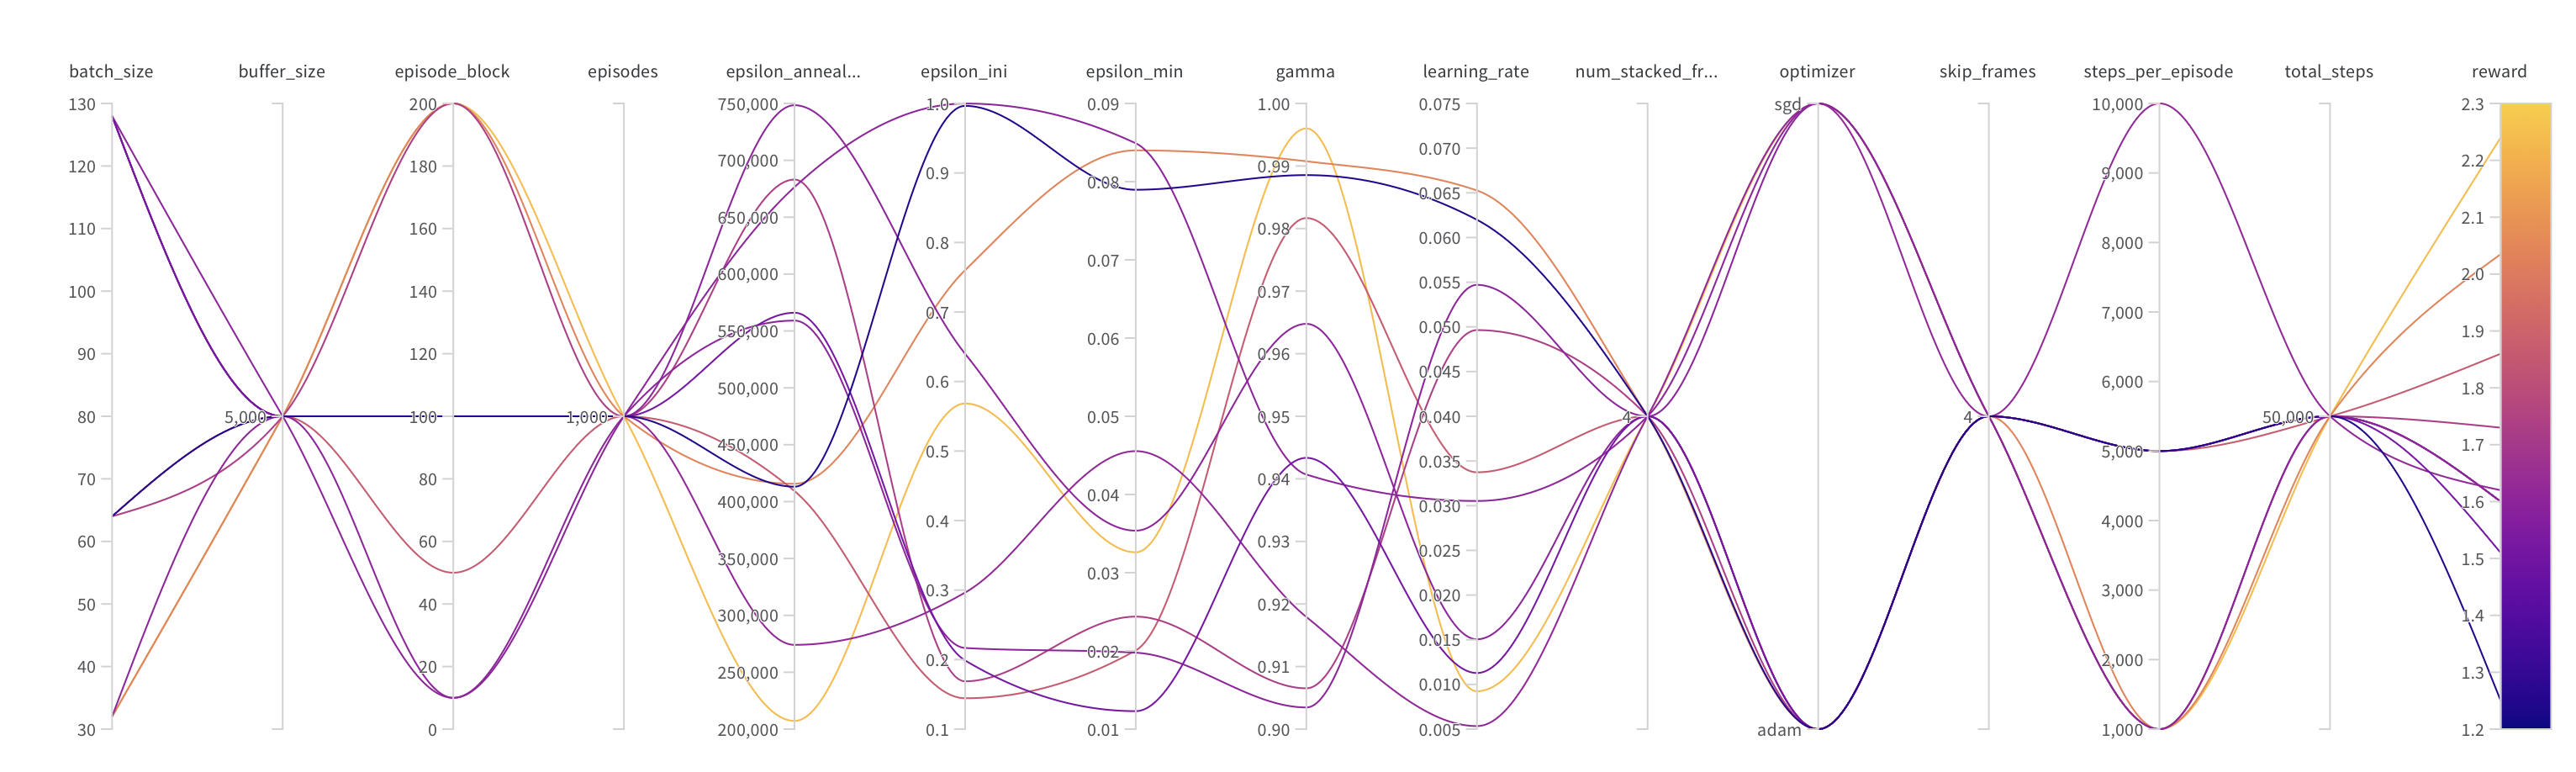

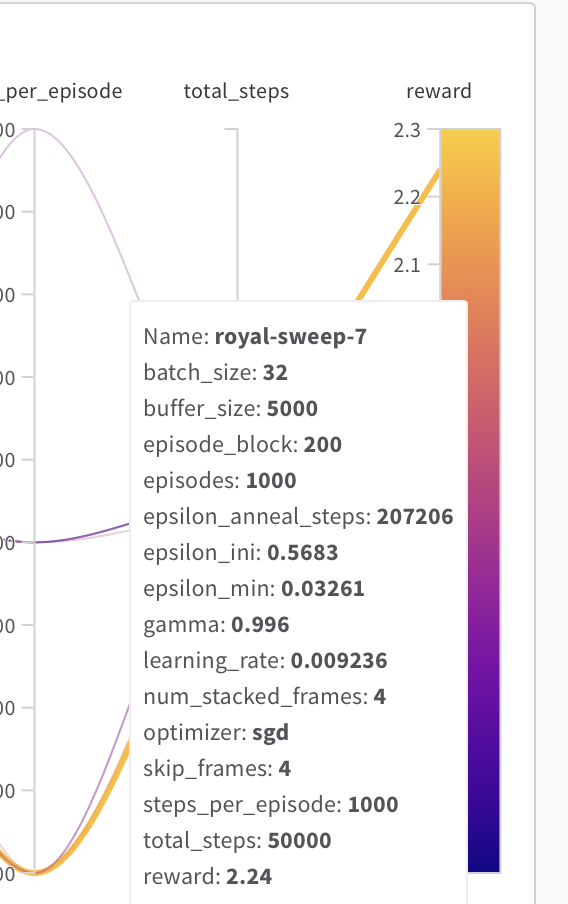

Como puede observarse en la imagen, existen hiperparámetros de consideración para utilizar en una nueva etapa de entrenamiento. Si bien dichos hiperparámetros no garantizar mejores valores de recompensa para el agente, sugieren que -utilizando una mayor cantidad de episodios- se lograrían mayores valores de recompensa para el agente.

# Comparaciones, Resultados, Comentarios...


Como se comentara, se encontraron diversos problemas con el entrenamiento del modelo, el cual, al parecer, luego de diversas pruebas, se puede atribuir al proceso de salvado del modelo (red). Dicho proceso, parece afectar de alguna manera el entrenamiento del modelo, haciendo descender el promedio de los rewards obtenidos.
Por otro lado, se pudo observar que existieron promedios de rewards en el entorno de los 20, haciendo pensar que con los hiperparámetros obtenidos de la experimentación mediante Weight and Bias, seguramente se lograrían mejores valores (rewards) durante las etapas de entrenamiento. Por cuestiones de restricciones de tiempo, no fue posible profundizar más en esta dinámica, aunque sí se lograron obtener valores de hiperparámetros que facilitarían nuevas pruebas de entrenamiento.

Por otro lado, en lo que refiere a la experimentación con Double DQN, no se lograron mejores resultados. Sin embargo, es posible que esto pueda atribuirse también a los problemas detectados durante el entrenamiento de DQN, haciendo sospechar que dicho modelo, también se vio afectado por este problema. Quedaría para una segunda instancia, seguir profundizando el entrenamiento con dicho modelo para confirmar (o refutar) la teoría que la experimentación mediante Double DQN, si bien debiera arrojar mejores valores de recompensa, éstos no fueron alcanzados por los problemas encontrados.

Como conclusión, puede confirmarse que la **utilización de una red neuronal para el mantenimiento de los estados, permite abordar problemas de entrenamiento más complejos** en lo que a cantidad de estados se refiere, los cuales, mediante metodologías tabulares (como Q-Learning), serían computacionalmente muy costosos -o incluso al día de hoy- imposibles de mantener para el entrenamiento de un agente.